In [1]:
# Import necessary packages

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import norm
from operator import itemgetter
from sklearn.model_selection import cross_val_score

In [2]:
# Import the datasets

dfHistorical = pd.read_csv('historical-mvps.csv')
dfCurrent = pd.read_csv('current-mvp-ladder.csv')
dfChange = pd.read_csv('predictions-change.csv')

In [3]:
# Preview the historical dataset

dfHistorical.head()

,Rank,Player,Age,Tm,Pts Won,Pts Max,Share,G,Team Wins,Overall Seed,...,3P%,FT%,WS,WS/48,VORP,BPM,G-Lockout,Wins-Lockout,WS-Lockout,VORP-Lockout
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,221,0.665,82.0,60.0,2,...,0.000,0.765,14.8,0.227,6.8,6.7,NaN,NaN,NaN,NaN
1,2,Julius Erving,29,PHI,31.5,221,0.143,78.0,59.0,3,...,0.200,0.787,12.5,0.213,6.5,7.2,NaN,NaN,NaN,NaN
2,3,George Gervin,27,SAS,19.0,221,0.086,78.0,41.0,10,...,0.314,0.852,10.6,0.173,3.1,2.2,NaN,NaN,NaN,NaN
3,4,Larry Bird,23,BOS,15.0,221,0.068,82.0,61.0,1,...,0.406,0.836,11.2,0.182,5.4,5.3,NaN,NaN,NaN,NaN
4,5,Tiny Archibald,31,BOS,2.0,221,0.009,80.0,61.0,1,...,0.222,0.830,8.9,0.148,1.5,0.0,NaN,NaN,NaN,NaN


# Create models

In [4]:
train, test = train_test_split(dfHistorical, test_size = 0.25, random_state = 10)

xtrain = train[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
ytrain = train[['Share']]

xtest = test[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
ytest = test[['Share']]

In [5]:
# Create function that gives accuracy scores for each model

def scores(y, model):
    
    model.fit(xtrain, ytrain.values.ravel())
    y_pred = model.predict(xtest)
    
    print("Mean squared error: %.3f" % mean_squared_error(ytest, y_pred))
    print('R2 score: %.3f' % r2_score(ytest, y_pred))

    cvScore = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'r2')
    print("R2 cross validation score: %0.2f (+/- %0.2f)" % (cvScore.mean(), cvScore.std() * 2))
    
    for i in y_pred:
        y.append(i)

In [6]:
svr = SVR(kernel='rbf', gamma=1e-4, C=100, epsilon = .1)

y_svr = []

scores(y_svr, svr)

Mean squared error: 0.028
R2 score: 0.708
R2 cross validation score: 0.63 (+/- 0.10)


In [7]:
rf = RandomForestRegressor(random_state = 9, n_estimators = 100, criterion = 'mse')

y_rf = []

scores(y_rf, rf)

Mean squared error: 0.035
R2 score: 0.628
R2 cross validation score: 0.50 (+/- 0.17)


In [8]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')

y_knn = []

scores(y_knn, knn)

Mean squared error: 0.035
R2 score: 0.633
R2 cross validation score: 0.53 (+/- 0.15)


In [9]:
dnn = MLPRegressor(
    solver='lbfgs',
    hidden_layer_sizes=100,
    max_iter=10000,
    random_state=987654321,
    activation='identity',
    learning_rate ='invscaling')

y_dnn = []

scores(y_dnn, dnn)

Mean squared error: 0.036
R2 score: 0.619
R2 cross validation score: 0.57 (+/- 0.02)


# Prediction

In [10]:
dfCurrentNames = dfCurrent.iloc[:, 1]
dfCurrentPredict = dfCurrent[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]

dfCurrent.head()

,Rank,Player,Age,Tm,G,Team Wins,Overall Seed,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM
0,1,Giannis (1),24,MIL,72,60,1,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,0.292,7.6,10.8
1,2,Harden (2),29,HOU,78,53,5,36.8,36.1,6.6,7.5,2.0,0.7,0.442,0.368,0.879,15.2,0.254,9.9,11.7
2,3,PG13 (3),28,OKC,77,49,10,36.9,28.0,8.2,4.1,2.2,0.4,0.438,0.386,0.839,11.9,0.201,5.3,5.5
3,4,Curry (4),30,GSW,69,57,3,33.8,27.3,5.3,5.2,1.3,0.4,0.472,0.437,0.916,9.7,0.199,4.9,6.3
4,5,Embiid (5),24,PHI,64,51,7,33.7,27.5,13.6,3.7,0.7,1.9,0.484,0.300,0.804,8.7,0.194,3.3,4.1


## SVR 

In [11]:
svrPredict = svr.predict(dfCurrentPredict)
svrPredict = svrPredict.tolist()

for (i, j) in zip(dfCurrentNames, svrPredict):
    print(i, j)

Giannis (1) 0.7286191761570091
Harden (2) 0.7875271888195226
PG13 (3) 0.16421177557461242
Curry (4) 0.25099988383339955
Embiid (5) 0.15449635629515335
Jokic (6) 0.30700032494624274
KD (7) 0.2685559907589674
Lillard (8) 0.20377775873859427
Kawhi (9) 0.21812648735135376
Westbrook (10) 0.0950196319395058


In [12]:
svrListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, svrPredict)]
svrDataUnsorted = [row[1] for row in svrListUnsorted]
svrList = sorted(svrListUnsorted, key = itemgetter(1), reverse = True)

svrData = [row[1] for row in svrList]
svrNames = [row[0] for row in svrList]
print(svrList)

x_svr = np.arange(len(svrData))

[['Harden (2)', 0.7875271888195226], ['Giannis (1)', 0.7286191761570091], ['Jokic (6)', 0.30700032494624274], ['KD (7)', 0.2685559907589674], ['Curry (4)', 0.25099988383339955], ['Kawhi (9)', 0.21812648735135376], ['Lillard (8)', 0.20377775873859427], ['PG13 (3)', 0.16421177557461242], ['Embiid (5)', 0.15449635629515335], ['Westbrook (10)', 0.0950196319395058]]


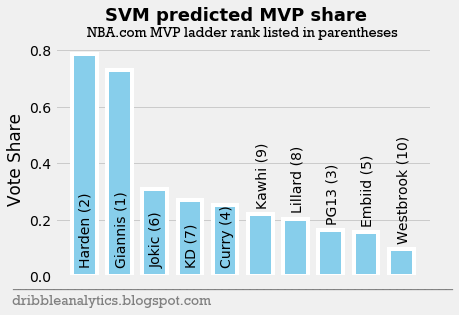

In [13]:
plt.style.use('fivethirtyeight')

svr, ax = plt.subplots()

ax.bar(x_svr, svrData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = svrNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 4:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <=4:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    
svr.suptitle("SVM predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

svr.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

svr.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

svr.savefig('svr.png', dpi = 400, bbox_inches = 'tight')

## RF

In [14]:
rfPredict = rf.predict(dfCurrentPredict)
rfPredict = rfPredict.tolist()

for (i, j) in zip(dfCurrentNames, rfPredict):
    print(i, j)

Giannis (1) 0.6678600000000001
Harden (2) 0.4907099999999999
PG13 (3) 0.18027999999999994
Curry (4) 0.31526999999999983
Embiid (5) 0.1856300000000001
Jokic (6) 0.21677999999999994
KD (7) 0.09460999999999997
Lillard (8) 0.12203999999999997
Kawhi (9) 0.16529999999999995
Westbrook (10) 0.06857999999999995


In [15]:
rfListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, rfPredict)]
rfDataUnsorted = [row[1] for row in rfListUnsorted]
rfList = sorted(rfListUnsorted, key = itemgetter(1), reverse = True)

rfData = [row[1] for row in rfList]
rfNames = [row[0] for row in rfList]
print(rfList)

x_rf = np.arange(len(rfData))

[['Giannis (1)', 0.6678600000000001], ['Harden (2)', 0.4907099999999999], ['Curry (4)', 0.31526999999999983], ['Jokic (6)', 0.21677999999999994], ['Embiid (5)', 0.1856300000000001], ['PG13 (3)', 0.18027999999999994], ['Kawhi (9)', 0.16529999999999995], ['Lillard (8)', 0.12203999999999997], ['KD (7)', 0.09460999999999997], ['Westbrook (10)', 0.06857999999999995]]


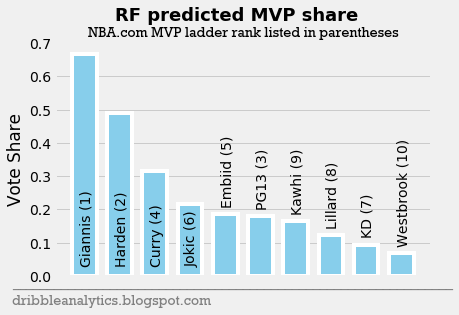

In [16]:
plt.style.use('fivethirtyeight')

rf, ax = plt.subplots()

ax.bar(x_rf, rfData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = rfNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 3:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 3:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
rf.suptitle("RF predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

rf.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

rf.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

rf.savefig('rf.png', dpi = 400, bbox_inches = 'tight')

## k-NN

In [17]:
knnPredict = knn.predict(dfCurrentPredict)
knnPredict = knnPredict.tolist()

for (i, j) in zip(dfCurrentNames, knnPredict):
    print(i, j)

Giannis (1) 0.7151428571428571
Harden (2) 0.648
PG13 (3) 0.279
Curry (4) 0.1907142857142857
Embiid (5) 0.11985714285714286
Jokic (6) 0.18299999999999997
KD (7) 0.1692857142857143
Lillard (8) 0.13685714285714284
Kawhi (9) 0.1858571428571429
Westbrook (10) 0.08642857142857144


In [18]:
knnListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, knnPredict)]
knnDataUnsorted = [row[1] for row in knnListUnsorted]
knnList = sorted(knnListUnsorted, key = itemgetter(1), reverse = True)

knnData = [row[1] for row in knnList]
knnNames = [row[0] for row in knnList]
print(knnList)

x_knn = np.arange(len(knnData))

[['Giannis (1)', 0.7151428571428571], ['Harden (2)', 0.648], ['PG13 (3)', 0.279], ['Curry (4)', 0.1907142857142857], ['Kawhi (9)', 0.1858571428571429], ['Jokic (6)', 0.18299999999999997], ['KD (7)', 0.1692857142857143], ['Lillard (8)', 0.13685714285714284], ['Embiid (5)', 0.11985714285714286], ['Westbrook (10)', 0.08642857142857144]]


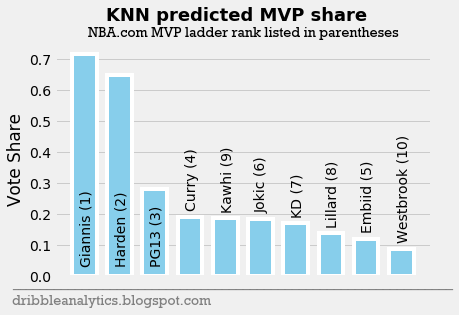

In [19]:
plt.style.use('fivethirtyeight')

knn, ax = plt.subplots()

ax.bar(x_knn, knnData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = knnNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 2:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 2:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
knn.suptitle("KNN predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

knn.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

knn.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

knn.savefig('knn.png', dpi = 400, bbox_inches = 'tight')

## DNN

In [20]:
dnnPredict = dnn.predict(dfCurrentPredict)
dnnPredict = dnnPredict.tolist()

for (i, j) in zip(dfCurrentNames, dnnPredict):
    print(i, j)

Giannis (1) 0.592049067164494
Harden (2) 0.6969126842214026
PG13 (3) 0.25150050627280884
Curry (4) 0.24183562365804145
Embiid (5) 0.22740861079328645
Jokic (6) 0.310359705171414
KD (7) 0.28996040494474773
Lillard (8) 0.28495507510544615
Kawhi (9) 0.213921710294261
Westbrook (10) 0.17432230204981836


In [21]:
dnnListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, dnnPredict)]
dnnDataUnsorted = [row[1] for row in dnnListUnsorted]
dnnList = sorted(dnnListUnsorted, key = itemgetter(1), reverse = True)

dnnData = [row[1] for row in dnnList]
dnnNames = [row[0] for row in dnnList]
print(dnnList)

x_dnn = np.arange(len(dnnData))

[['Harden (2)', 0.6969126842214026], ['Giannis (1)', 0.592049067164494], ['Jokic (6)', 0.310359705171414], ['KD (7)', 0.28996040494474773], ['Lillard (8)', 0.28495507510544615], ['PG13 (3)', 0.25150050627280884], ['Curry (4)', 0.24183562365804145], ['Embiid (5)', 0.22740861079328645], ['Kawhi (9)', 0.213921710294261], ['Westbrook (10)', 0.17432230204981836]]


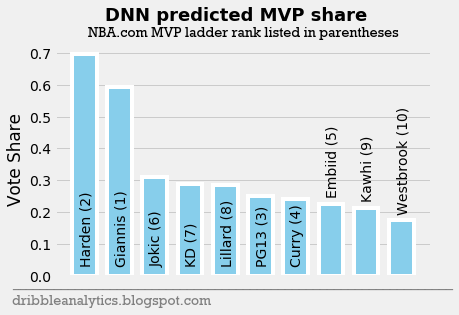

In [22]:
plt.style.use('fivethirtyeight')

dnn, ax = plt.subplots()

ax.bar(x_dnn, dnnData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = dnnNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 6:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 6:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
dnn.suptitle("DNN predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

dnn.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

dnn.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

dnn.savefig('dnn.png', dpi = 400, bbox_inches = 'tight')

## Average

In [23]:
avgPredict = []

for (i, j, h, k) in zip(svrDataUnsorted, rfDataUnsorted, knnDataUnsorted, dnnDataUnsorted):
    avgPredict.append((i + j + h + k) / 4)

avgList = [[i, j] for i, j in zip(dfCurrentNames, avgPredict)]
avgList = sorted(avgList, key = itemgetter(1), reverse = True)

avgData = [row[1] for row in avgList]
avgNames = [row[0] for row in avgList]
print(avgList)

x_avg = np.arange(len(avgData))

[['Giannis (1)', 0.6759177751160901], ['Harden (2)', 0.6557874682602314], ['Jokic (6)', 0.2542850075294142], ['Curry (4)', 0.24970494830143164], ['PG13 (3)', 0.2187480704618553], ['KD (7)', 0.20560302749735734], ['Kawhi (9)', 0.1958013351256894], ['Lillard (8)', 0.1869074941752958], ['Embiid (5)', 0.1718480274863957], ['Westbrook (10)', 0.10608762635447389]]


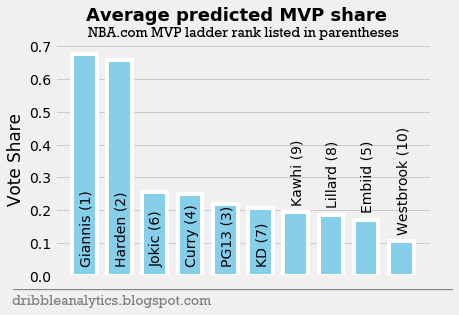

In [24]:
plt.style.use('fivethirtyeight')

avg, ax = plt.subplots()

ax.bar(x_avg, avgData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = avgNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 5:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 5:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
avg.suptitle("Average predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

avg.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

avg.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

avg.savefig('avg.png', dpi = 400, bbox_inches = 'tight')

# Change in predictions

In [25]:
dfChange.head()

,Player,Average (mid-season),Average (ASB),Average (end of season),Difference,End - ASB,End - mid-season
0,Giannis,0.583803,0.719405,0.675918,0.135602,-0.043487,0.092115
1,Harden,0.433169,0.563916,0.655787,0.130747,0.091871,0.222619
2,PG13,0.204343,0.332271,0.218748,0.127929,-0.113523,0.014405
3,KD,0.274898,0.329670,0.205603,0.054772,-0.124067,-0.069295
4,Curry,0.259863,0.282256,0.249705,0.022393,-0.032551,-0.010158


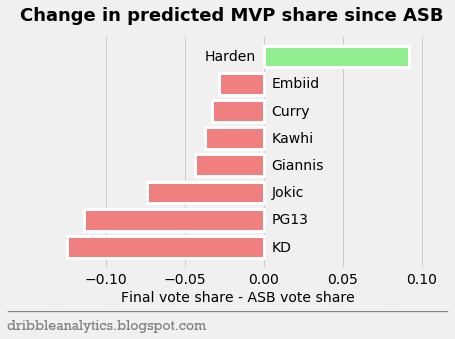

In [26]:
plt.style.use('fivethirtyeight')
change_asb, ax = plt.subplots()

asb_list = [[i, j] for i, j in zip(dfChange['Player'], dfChange['End - ASB'])]
asb_list = sorted(asb_list, key = itemgetter(1), reverse = False)

asb_data = [row[1] for row in asb_list]
asb_names = [row[0] for row in asb_list]

y_pos = np.arange(len(asb_data))

colorList = []

for i in asb_data:
    if i < 0:
        colorList.append('lightcoral')
    elif i > 0:
        colorList.append('lightgreen')

ax.barh(y_pos, asb_data, color = colorList, edgecolor = 'white', linewidth = 3)

labels = [i for i in asb_names]

rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_y()
    if rect.get_y() < 6:
        ax.text(rect.get_x() + .005, height + .15, label,
        ha='left', va='bottom', color = 'black')
    elif rect.get_y() >= 6:
        ax.text(rect.get_x() - .005, height + .15, label,
        ha='right', va='bottom', color = 'black')

change_asb.suptitle("Change in predicted MVP share since ASB", weight = 'bold', size = 18)
ax.yaxis.set_visible(False)
ax.set_xlabel("Final vote share - ASB vote share", size = 14)

change_asb.text(x = -0.02, y = -0.07,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

change_asb.text(x = -0.02, y = -.14,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
 
change_asb.savefig('change-asb-2019.png', dpi = 400, bbox_inches = 'tight')

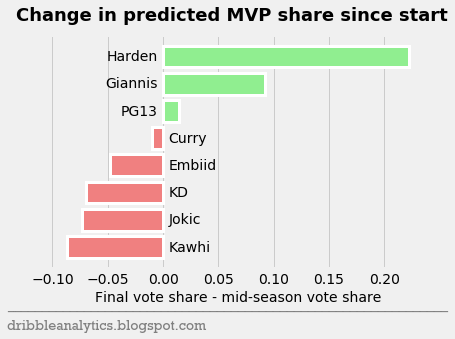

In [27]:
plt.style.use('fivethirtyeight')
change_start, ax = plt.subplots()

start_list = [[i, j] for i, j in zip(dfChange['Player'], dfChange['End - mid-season'])]
start_list = sorted(start_list, key = itemgetter(1), reverse = False)

start_data = [row[1] for row in start_list]
start_names = [row[0] for row in start_list]

y_pos = np.arange(len(start_data))

colorList = []

for i in start_data:
    if i < 0:
        colorList.append('lightcoral')
    elif i > 0:
        colorList.append('lightgreen')

ax.barh(y_pos, start_data, color = colorList, edgecolor = 'white', linewidth = 3)

labels = [i for i in start_names]

rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_y()
    if rect.get_y() < 4:
        ax.text(rect.get_x() + .005, height + .15, label,
        ha='left', va='bottom', color = 'black')
    elif rect.get_y() >= 4:
        ax.text(rect.get_x() - .005, height + .15, label,
        ha='right', va='bottom', color = 'black')

change_start.suptitle("Change in predicted MVP share since start", weight = 'bold', size = 18)
ax.yaxis.set_visible(False)
ax.set_xlabel("Final vote share - mid-season vote share", size = 14)

change_start.text(x = -0.02, y = -0.07,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

change_start.text(x = -0.02, y = -.14,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')
 
change_start.savefig('change-start-2019.png', dpi = 400, bbox_inches = 'tight')